## Задание 1

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from tqdm.auto import tqdm
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
%matplotlib inline

Для начала загрузим все файлы и изучим их

In [78]:
groups = pd.read_csv('Проект_2_groups.csv', sep = ';')

In [79]:
groups

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [80]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [81]:
groups.grp.value_counts() # тестовая группа в несколько раз больше контрольной

B    59813
A    14671
Name: grp, dtype: int64

In [82]:
groups_add = pd.read_csv('Проект_2_group_add.csv')

In [83]:
groups_add

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [84]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [85]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [86]:
active_studs = pd.read_csv('Проект_2_active_studs.csv')

In [87]:
active_studs

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [88]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [89]:
checks = pd.read_csv('Проект_2_checks.csv', sep = ';')

In [90]:
checks

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [91]:
checks = checks.rename(columns={'student_id': 'id'})

In [92]:
checks

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [93]:
# Переименуем колонку, чтобы удобнее было объединить датафреймы
active_studs = active_studs.rename(columns={'student_id': 'id'})

In [94]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      541 non-null    int64  
 1   rev     541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [95]:
# Объединяем датафреймы, используем левый join, чтобы не потерять значения в таблице active_studs,
# поскольку именно она показывает пользователей, которые посещали платформу во время проведения теста
grps = active_studs.merge(groups, how = 'left', on = 'id')
grps = grps.merge(checks, how = 'left', on = 'id')

In [96]:
grps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8341 non-null   int64  
 1   grp     8328 non-null   object 
 2   rev     392 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


In [97]:
grps

,id,grp,rev
0,581585,A,NaN
1,5723133,NaN,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
...,...,...,...
8336,1794344,B,NaN
8337,296883,B,NaN
8338,3598448,B,NaN
8339,3610547,B,290.0


In [98]:
grps.id.nunique() # все id уникальные

8341

In [99]:
# Считаем метрики, начнем с ARPU
arpu = grps.groupby(['grp'], as_index = False).agg({'rev':'sum', 'id':'count'})
arpu['ARPU'] = arpu.rev / arpu.id
arpu = arpu.rename(columns={'rev':'rev_sum', 'id':'id_count'})
arpu
# В контрольной группы мы получаем в среднем 47.44 рубля за пользователя, а в тестовой 57.86 рублей.

,grp,rev_sum,id_count,ARPU
0,A,72820.0000,1535,47.439739
1,B,393074.0035,6793,57.864567


In [100]:
# Считаем конверсию в покупку
conversion = grps.groupby('grp', as_index = False).agg({'rev':'count', 'id':'count'})
conversion['conversion'] = conversion.rev / conversion.id
conversion
# Конверсия в тестовой группе ниже, чем в контрольной.
# При этом средний чек на пользователя и средний чек в целом выше в тестовой группе, чем в контрольной.

,grp,rev,id,conversion
0,A,78,1535,0.050814
1,B,313,6793,0.046077


In [101]:
A = grps.query('grp == "A"')

In [102]:
B = grps.query('grp == "B"')

In [103]:
A

,id,grp,rev
0,581585,A,NaN
3,4238589,A,NaN
7,1394612,A,NaN
21,5194768,A,NaN
22,3658923,A,NaN
...,...,...,...
8317,3208984,A,NaN
8320,2900558,A,NaN
8326,1161774,A,NaN
8330,5006972,A,NaN


Избавимся от нулевых значений, чтобы можно было корректно провести A/B тест. Если этого не сделать, то не получится правильно сравнить среднее в двух группах.

In [104]:
grps_no_null = grps.dropna()

In [105]:
A_no_null = grps_no_null.query('grp == "A"')
A_no_null

,id,grp,rev
62,1184303,A,1530.0
99,720651,A,1980.0
306,4337103,A,580.0
392,332387,A,2910.0
439,1659434,A,690.0
...,...,...,...
7950,445767,A,3660.0
8025,1202202,A,2910.0
8027,2306271,A,290.0
8204,1390994,A,398.0


In [106]:
B_no_null = grps_no_null.query('grp == "B"')
B_no_null

,id,grp,rev
67,3354191,B,1900.0001
77,3278734,B,1900.0000
193,1232221,B,1900.0000
195,3821501,B,1900.0000
211,1036096,B,1900.0000
...,...,...,...
8109,2692209,B,1900.0001
8191,2081846,B,1900.0000
8201,3890326,B,199.0000
8277,3910596,B,597.0000


In [107]:
print(f"ARPPU_A: {A_no_null.rev.mean():.4f}")
print(f"ARPPU_B: {B_no_null.rev.mean():.4f}")

ARPPU_A: 933.5897
ARPPU_B: 1255.8275


Среднее в тестовой группе больше, чем в контрольной

In [108]:
print(f"A_rev_median: {A_no_null.rev.median():.4f}")
print(f"B_rev_median: {B_no_null.rev.median():.4f}")

A_rev_median: 585.0000
B_rev_median: 1140.0000


Медиана в тестовой группе больше, чем в контрольной.

In [109]:
print(f"A_rev_std: {A_no_null.rev.std():.4f}")
print(f"B_rev_std: {B_no_null.rev.std():.4f}")

A_rev_std: 919.9327
B_rev_std: 791.2934


Стандартное отклонение у тестовой группы меньше, чем у контрольной.

Проверим наши данные на нормальность

In [110]:
ss.normaltest(A_no_null['rev'])

NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)

In [111]:
ss.normaltest(B_no_null['rev'])

NormaltestResult(statistic=7.022269699078301, pvalue=0.029863005181946005)

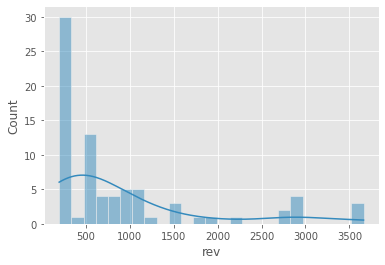

In [112]:
sns.histplot(A_no_null.rev, kde=True,bins = 25);

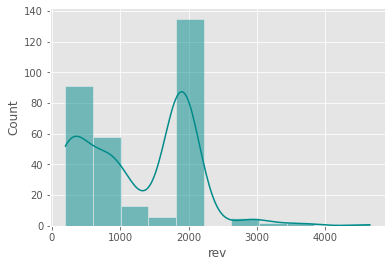

In [113]:
sns.histplot(B_no_null.rev, kde=True, color = '#008B8B');

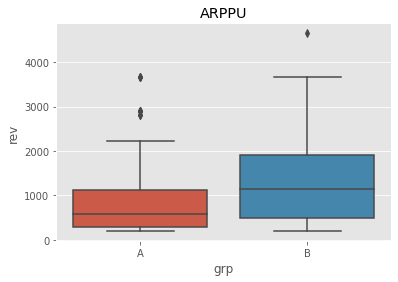

In [114]:
sns.boxplot(x='grp', y='rev', data=grps_no_null).set_title('ARPPU');

Согласно нормалтесту распределение группы А отчается от нормального на 5% уровне значимости, а распределение группы B проходит проверку на нормальность, это также можно заметить и на диаграммах. Но для использования параметрического теста, обе группы должны проходить проверку на нормальность, а также дисперсии у групп должны быть равно. Поэтому, мы должны использовать непараметрический критерий, в данном случае воспользуемся бутстэпом для оценки статистической значимости разниц конверсии, ARPU и ARPPU. Для этого вернемся к изначальным датафреймам с нулевыми значениями.

In [115]:
# добавим бинарную колонку, где 1 - пользователь совершил покупку, 0 - не совершал. Это нужно чтобы оценить конверсию через бутстрэп
A['is_rev'] = np.where(A.rev > 0, 1, 0)

In [116]:
B['is_rev'] = np.where(B.rev > 0, 1, 0)

In [117]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

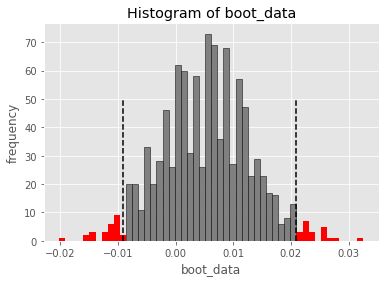

In [118]:
booted_data_conversion = get_bootstrap(A['is_rev'], B['is_rev'])

In [119]:
booted_data_conversion["p_value"]

0.4866414809945053

In [120]:
booted_data_conversion["quants"]

,0
0.025,-0.009121
0.975,0.020847


Что касается конверсии, то ее различие в группах A и B не является статистически значимым, так как доверительный интервал проходит через ноль, а p-value > 0.05.

In [121]:
# Заполним пропуски нулями, то есть тех пользователей, которые ничего не купили.
# Это нужно для оценки разницы ARPU с помощью бутстрэпа
A['rev'] = A.rev.fillna(0)

In [122]:
B['rev'] = B.rev.fillna(0)

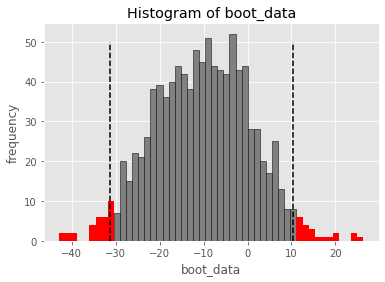

In [123]:
booted_data_ARPU = get_bootstrap(A['rev'], B['rev'])

In [124]:
booted_data_ARPU["p_value"]

0.34584617538827556

In [125]:
booted_data_ARPU["quants"]

,0
0.025,-31.414626
0.975,10.247850


Разница в ARPU также не оказалась статистически значимой, на это также указывает p-value, которое больше 0.05 и доверительный интервал, который проходит через ноль.

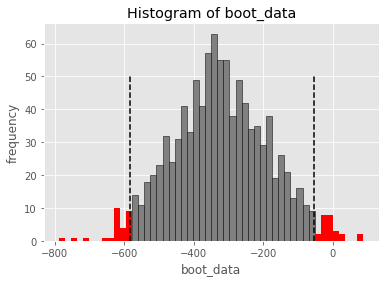

In [126]:
booted_data_arppu = get_bootstrap(A_no_null['rev'], B_no_null['rev'])

In [127]:
booted_data_arppu['p_value']

0.017728612545944093

In [128]:
booted_data_arppu["quants"]

,0
0.025,-582.716041
0.975,-54.268287


Различие ARPPU между группами А и B статистически значимо, доверительный интервал не проходит через ноль, а p-value < 0.05

Таким образом, конверсия в тестовой группе меньше, чем в контрольной, однако их отличие не оказалось статистически значимым. Различие в ARPU тоже не оказалось статистически значимым, однако различие ARPPU показало статистическую значимость. Таким образом, мы **можем внедрять новую механику на всех пользователей**. Это позволит нам повысить средний чек.

## Задание 3

Теперь пересчитаем метрики и визуализируем их, учтя файл, который нам прислали через 2 дня после анализа

conversion_A: 0.0507
conversion_B: 0.0462
ARPU_A: 47.3472
ARPU_B: 58.0588
ARPPU_A: 933.5897
ARPPU_B: 1257.8790
A_rev_median: 585.0000
B_rev_median: 1140.0000


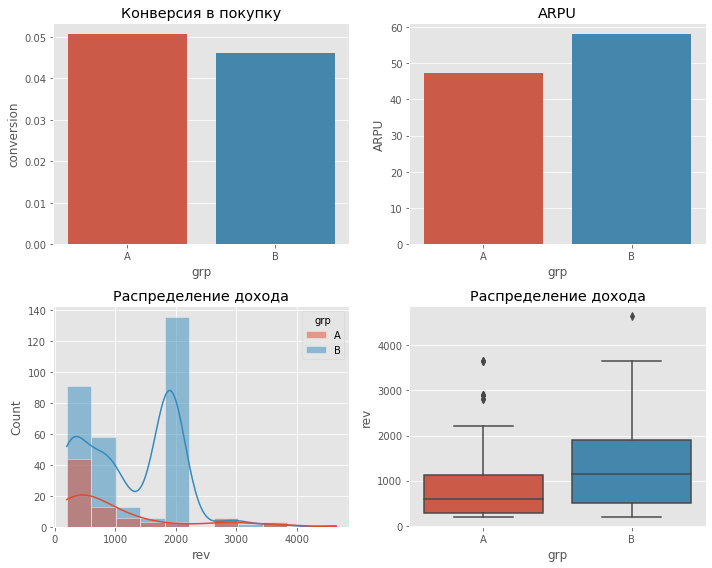

In [129]:
def groups_with_new(active_studs, groups, groups_add, checks):
    # Объединяем датафреймы с учетом нового файла
    new_groups = pd.concat([groups, groups_add], axis=0, join='outer')
    df = active_studs.merge(new_groups, how='left', on='id').merge(checks, how='left', on='id')
    
    # Считаем метрики
    conversion_new = df.groupby('grp', as_index=False).agg({'rev':'count', 'id':'count'})
    conversion_new['conversion'] = conversion_new.rev / conversion_new.id
    print(f"conversion_A: {conversion_new.conversion.iloc[0]:.4f}")
    print(f"conversion_B: {conversion_new.conversion.iloc[1]:.4f}")
    
    arpu_new = df.groupby(['grp'], as_index=False).agg({'rev':'sum', 'id':'count'})
    arpu_new['ARPU'] = arpu_new.rev / arpu_new.id
    print(f"ARPU_A: {arpu_new.ARPU.iloc[0]:.4f}")
    print(f"ARPU_B: {arpu_new.ARPU.iloc[1]:.4f}")
    
    # Удаляем нулевые значения для проведения теста
    df = df.dropna()
    
    # Делим датафрейм на контрольную и тестовую группы
    A_new = df.query('grp == "A"')
    B_new = df.query('grp == "B"')
    print(f"ARPPU_A: {A_new.rev.mean():.4f}")
    print(f"ARPPU_B: {B_new.rev.mean():.4f}")
    print(f"A_rev_median: {A_new.rev.median():.4f}")
    print(f"B_rev_median: {B_new.rev.median():.4f}")
    
    # Визуализируем метрики
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8)) # заданим количество графиков и размер фигуры
    
    sns.barplot(x='grp', y='conversion', data=conversion_new, ax=ax[0, 0]) # Столбчатая диаграмма конверсии групп А и B
    ax[0, 0].set_title('Конверсия в покупку')
    
    sns.barplot(x='grp', y='ARPU', data=arpu_new, ax=ax[0, 1]) # Столбчатая диаграмма ARPU групп A и B
    ax[0, 1].set_title('ARPU')
    
    sns.histplot(x='rev', hue='grp', data=df, kde=True, ax=ax[1, 0])
    ax[1, 0].set_title('Распределение дохода') # Гистограмма распределения дохода без учета нулевых значений
    
    sns.boxplot(x='grp', y='rev', data=df, ax=ax[1, 1])
    ax[1, 1].set_title('Распределение дохода') # Ящики с усами дохода по группам
    
    plt.tight_layout() # укажем оптимальное расстояние между графиками

groups_with_new(active_studs, groups, groups_add, checks)